## Importing Libraries

In [1]:
import albumentations as A
import os
import ssl
import imageio.v2 as imageio 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
from utils import *
from data_loader import *
from train import * 
from segmentation import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [26]:
# Define paths to the directory containing the images and masks
img_path = (
    "archive/dataset/semantic_drone_dataset/original_images/"
)
mask_path = "archive/dataset/semantic_drone_dataset/label_images_semantic/"

### Hyperparameters

In [11]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
use_patch = False
save_path = "DeepLabV3_ResNet50.pt"
batch_size = 3
model_num = 2
num_classes = 23
max_lr = 1e-3
epochs = 25
weight_decay = 1e-4

## Vizualizing a sample from dataset

In [12]:
image_list = os.listdir(img_path)
mask_list = os.listdir(mask_path)

image_list = [img_path + i for i in image_list ] 
mask_list = [mask_path + i for i in mask_list ] 

image_list = sorted(image_list)
mask_list = sorted(mask_list)

print('Number of images are ', len(image_list))

print(image_list[0])
print(mask_list[0])

Number of images are  400
../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/000.jpg
../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/000.png


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Masked Image')

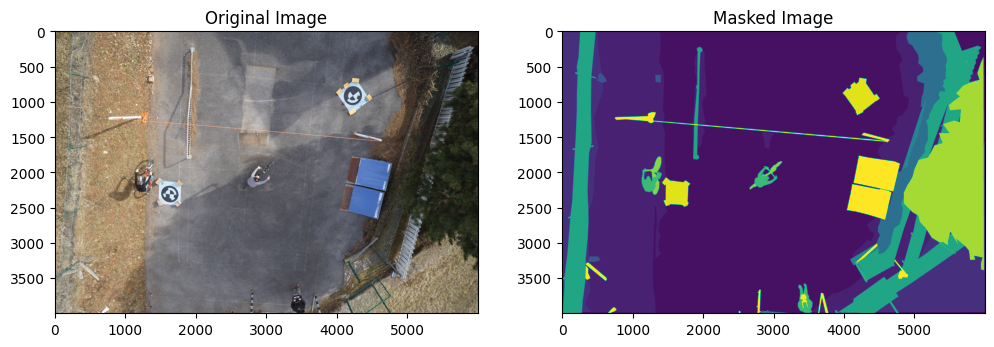

In [13]:
idx = 10
img = imageio.imread(image_list[idx])
print(img.shape)

mask = imageio.imread(mask_list[idx])

print(mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(12, 10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Masked Image')

## Loading Dataset

In [22]:
df = create_image_id_dataframe(img_path)

X_train_and_val, X_test = train_test_split(
    df["id"].values, test_size=0.1, random_state=19
)
X_train, X_val = train_test_split(X_train_and_val, test_size=0.15, random_state=19)

print("Train Size ", len(X_train))
print("Test Size ", len(X_test))
print("Val Size ", len(X_val))

t_train = A.Compose(
    [
        A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)
t_val = A.Compose(
    [
        A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(),
        A.GridDistortion(p=0.2),
    ]
)
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

train_dataset = DataGenerator(
    img_path,
    mask_path,
    X_train,
    mean,
    std,
    transform=t_train,
    normalize=True,
    patch=use_patch,
)
val_dataset = DataGenerator(
    img_path, mask_path, X_val, transform=t_val, normalize=True, patch=use_patch
)
test_dataset = DataGenerator(img_path, mask_path, X_test, transform=t_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Size  306
Test Size  40
Val Size  54


## Defining and Loading Pre-trained Segmentation Model

In [15]:
model = SegmentationModel(num_classes)

# model = torch.load("/kaggle/working/deeplabv3_resnet50.pt")

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 158MB/s]  


## Define Segmentation Model Hyperparameters

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

In [23]:
history = train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, device, patch=use_patch)
torch.save(model, save_path)
print(f"Saved {save_path}")

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/25: Train Loss: 1.575, Val Loss: 1.158, Train IoU: 0.170, Val IoU: 0.214, Train Acc: 0.696, Val Acc: 0.778


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2/25: Train Loss: 1.254, Val Loss: 0.979, Train IoU: 0.222, Val IoU: 0.238, Train Acc: 0.756, Val Acc: 0.798


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3/25: Train Loss: 1.112, Val Loss: 0.881, Train IoU: 0.255, Val IoU: 0.268, Train Acc: 0.773, Val Acc: 0.810


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4/25: Train Loss: 0.932, Val Loss: 0.805, Train IoU: 0.305, Val IoU: 0.314, Train Acc: 0.817, Val Acc: 0.836


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5/25: Train Loss: 0.851, Val Loss: 0.716, Train IoU: 0.327, Val IoU: 0.335, Train Acc: 0.827, Val Acc: 0.849


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6/25: Train Loss: 0.729, Val Loss: 0.637, Train IoU: 0.364, Val IoU: 0.367, Train Acc: 0.852, Val Acc: 0.861


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7/25: Train Loss: 0.675, Val Loss: 0.592, Train IoU: 0.389, Val IoU: 0.379, Train Acc: 0.865, Val Acc: 0.871


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8/25: Train Loss: 0.603, Val Loss: 0.552, Train IoU: 0.412, Val IoU: 0.420, Train Acc: 0.877, Val Acc: 0.877


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9/25: Train Loss: 0.552, Val Loss: 0.517, Train IoU: 0.427, Val IoU: 0.418, Train Acc: 0.888, Val Acc: 0.881


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10/25: Train Loss: 0.504, Val Loss: 0.482, Train IoU: 0.448, Val IoU: 0.450, Train Acc: 0.894, Val Acc: 0.888


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11/25: Train Loss: 0.495, Val Loss: 0.498, Train IoU: 0.470, Val IoU: 0.452, Train Acc: 0.894, Val Acc: 0.881


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12/25: Train Loss: 0.452, Val Loss: 0.443, Train IoU: 0.498, Val IoU: 0.471, Train Acc: 0.904, Val Acc: 0.893


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13/25: Train Loss: 0.406, Val Loss: 0.422, Train IoU: 0.527, Val IoU: 0.497, Train Acc: 0.914, Val Acc: 0.899


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14/25: Train Loss: 0.369, Val Loss: 0.397, Train IoU: 0.548, Val IoU: 0.512, Train Acc: 0.920, Val Acc: 0.904


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15/25: Train Loss: 0.360, Val Loss: 0.412, Train IoU: 0.561, Val IoU: 0.530, Train Acc: 0.921, Val Acc: 0.897


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16/25: Train Loss: 0.352, Val Loss: 0.390, Train IoU: 0.568, Val IoU: 0.527, Train Acc: 0.922, Val Acc: 0.902


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17/25: Train Loss: 0.312, Val Loss: 0.378, Train IoU: 0.591, Val IoU: 0.540, Train Acc: 0.930, Val Acc: 0.905


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18/25: Train Loss: 0.295, Val Loss: 0.363, Train IoU: 0.604, Val IoU: 0.554, Train Acc: 0.932, Val Acc: 0.906


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19/25: Train Loss: 0.282, Val Loss: 0.352, Train IoU: 0.616, Val IoU: 0.551, Train Acc: 0.934, Val Acc: 0.907


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20/25: Train Loss: 0.279, Val Loss: 0.352, Train IoU: 0.622, Val IoU: 0.544, Train Acc: 0.933, Val Acc: 0.906


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21/25: Train Loss: 0.279, Val Loss: 0.383, Train IoU: 0.617, Val IoU: 0.530, Train Acc: 0.930, Val Acc: 0.896


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22/25: Train Loss: 0.328, Val Loss: 0.377, Train IoU: 0.599, Val IoU: 0.524, Train Acc: 0.917, Val Acc: 0.895


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23/25: Train Loss: 0.277, Val Loss: 0.369, Train IoU: 0.618, Val IoU: 0.533, Train Acc: 0.930, Val Acc: 0.900


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24/25: Train Loss: 0.244, Val Loss: 0.339, Train IoU: 0.630, Val IoU: 0.563, Train Acc: 0.939, Val Acc: 0.905


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25/25: Train Loss: 0.222, Val Loss: 0.332, Train IoU: 0.651, Val IoU: 0.572, Train Acc: 0.943, Val Acc: 0.910
Saved DeepLabV3_ResNet50.pt


## Evaluating the training performance

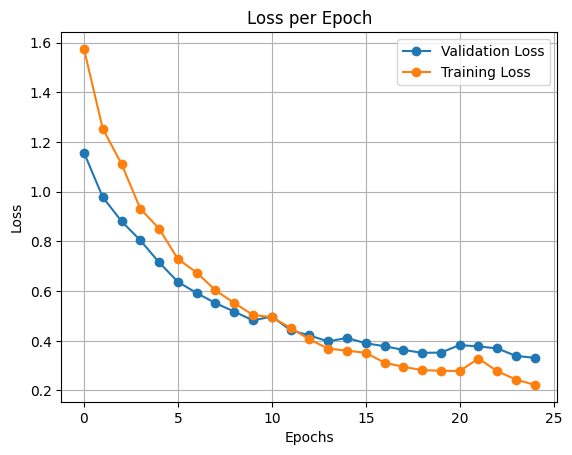

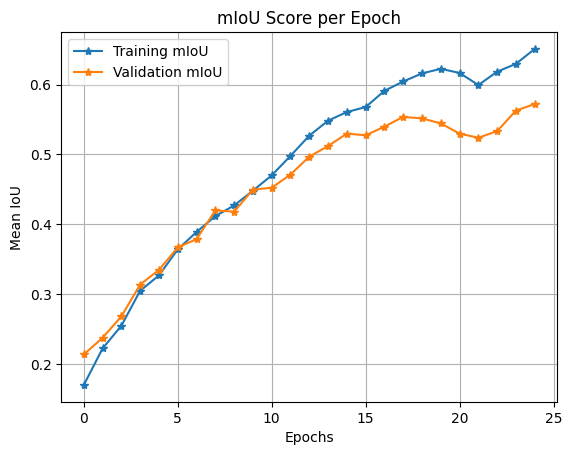

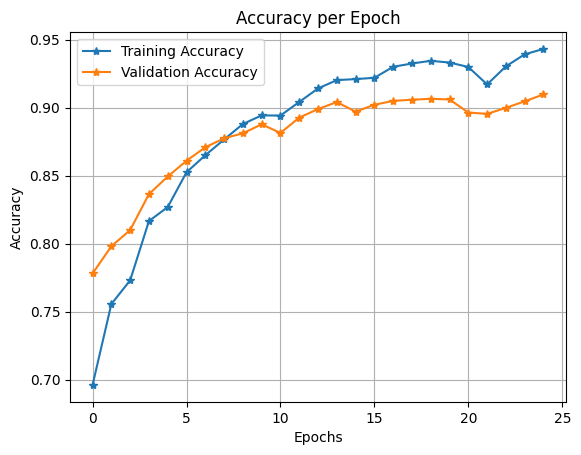

In [27]:
plot_loss_vs_epoch(history)
plot_iou_score_vs_epoch(history)
plot_accuracy_vs_epoch(history)